# Yoga for the Yoga-less
Parker Servello


__Objective:__  
My friend frequently ruminates aloud about his dream of operating a yoga studio. This project will be the first step in making that dream become reality. Since we are going to Denver, Colorado next week, we will work under the assumption that he will fall in love with it and want to settle down there. We will determine the best location for this endeavor by clustering neighborhoods together that typically have yoga studios in them, then choosing an area within that cluster that either has too few or no yoga studios.  

__Data Collection:__  
We will leverage geo-location data for the neighborhoods listed in wikipedia as well as nearby venue data queried from foursquare's API for each neighborhood's coordinates. The clusters will be formed using the venue type frequency for each neighborhood.



In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import folium
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import metrics
from scipy.spatial.distance import cdist

## Extracting neighborhood geo-data from wikipedia

First let's get a dataframe of the neighborhoods with their cardinal area and wiki href.

In [2]:
page = requests.get(r'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Denver')
soup = BeautifulSoup(page.text, 'lxml')

denver_division = [div.text for div in soup.find_all('span', class_='mw-headline')][:-3]

df = []
for div, lst in zip(denver_division,soup.find_all('ul')[1:11]):
    df.extend([(div, nbhd.text, nbhd['href']) for nbhd in lst.find_all('a')])
    
df = pd.DataFrame(df, columns=['Area','Neighborhood','href'])

df.head()

,Area,Neighborhood,href
0,Central,Baker,"/wiki/Baker,_Denver"
1,Central,Capitol Hill,"/wiki/Capitol_Hill,_Denver"
2,Central,Central Business District,/wiki/Downtown_Denver
3,Central,Cherry Creek,"/wiki/Cherry_Creek,_Denver"
4,Central,Cheesman Park,"/wiki/Cheesman_Park,_Denver"


Now we'll go to each of the neighborhood links to extract coordinates.

In [3]:
lat,lon = [],[]
for href in df['href']:
    
    url = 'https://en.wikipedia.org' + href
    
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'lxml')
    
    try:
        coord = soup.find_all('span', class_='geo')[0].text
        lat.append(coord.split(";")[0])
        lon.append(coord.split(" ")[1])
    
    except:
        lat.append("0")
        lon.append("0")
        
first_count = len(df)
        
# add latitude and longitude to dataframe and remove the href column  
df['Latitude'] = list(map(float,lat))
df['Longitude'] = list(map(float,lon))
df.drop('href', axis=1, inplace=True)

Let's remove neighborhoods that didn't have a wikipedia page.

In [4]:
df = df[df['Latitude'] != 0].reset_index(drop=True)

# store number of neighborhoods
second_count = len(df)

## Exploring the neighborhoods

In [5]:
print("Initially there were {} neighborhoods. {} were removed because there is no associated wikipedia page.\n\
Also, let's get rid of the airport and Montbello because they are practically outside of Denver.".
     format(first_count, first_count-second_count))


Initially there were 91 neighborhoods. 41 were removed because there is no associated wikipedia page.
Also, let's get rid of the airport and Montbello because they are practically outside of Denver.


In [6]:
df = df[[nbhd not in ['Denver International Airport','Montbello'] for nbhd in df['Neighborhood']]]
df.head()

,Area,Neighborhood,Latitude,Longitude
0,Central,Baker,39.723919,-104.995150
1,Central,Capitol Hill,39.733000,-104.983000
2,Central,Central Business District,39.745870,-104.992819
3,Central,Cherry Creek,39.720967,-104.949804
4,Central,Cheesman Park,39.732780,-104.965830


In [7]:
# create map of Denver using latitude and longitude values
map_denver = folium.Map(location=[39.719, -104.95], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Area'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_denver)  
    
map_denver

## Requesting data from Foursquare

First, we need to enter credentials from a Foursquare account.

In [8]:
CLIENT_ID = 'my_id'
CLIENT_SECRET = 'my_secret'
VERSION = '20180605'

Now we can request the data.

Creating a function that extracts the nearby venues

In [9]:
def get_nearby_venues(names, latitudes, longitudes, radius=1000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,  CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Running the function to create the dataframe of venues pulled from foursquare.

In [10]:
denver_venues = get_nearby_venues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])

There are going to be duplicate venues, so we should only attribute each venue to its' closest neighborhood. Let's compute the distance from each venue to each associated neighborhood and remove the duplicates.

In [11]:
denver_venues['Venue Distance'] = np.sqrt((denver_venues['Neighborhood Latitude']-denver_venues['Venue Latitude'])**2+(denver_venues['Neighborhood Longitude']-denver_venues['Venue Longitude'])**2)

denver_venues_reduced = denver_venues.sort_values('Venue Distance').drop_duplicates(['Venue','Venue Latitude','Venue Longitude'])
print("Removed {} duplicate venues. {} remain.".format(len(denver_venues)-len(denver_venues_reduced),len(denver_venues_reduced)))
denver_venues_reduced.head()

Removed 789 duplicate venues. 2167 remain.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Distance
2023,Chaffee Park,39.787432,-105.015827,Little Caesars Pizza,39.787400,-105.015902,Pizza Place,0.000082
732,Civic Center,39.739440,-104.988890,Civic Center Park,39.739370,-104.988776,Park,0.000134
1695,Five Points,39.754779,-104.978051,Five Points,39.754647,-104.978099,Neighborhood,0.000141
1448,Montclair,39.734914,-104.908769,Montclair Park,39.734769,-104.908689,Park,0.000165
1662,Five Points,39.754779,-104.978051,Coffee at The Point,39.754699,-104.977905,Coffee Shop,0.000167


## Exploratory Analysis

First we'll look at how the venues are distributed across the neighborhoods.

,Venue
count,48.000000
mean,45.145833
std,24.412231
min,9.000000
25%,26.000000
50%,40.000000
75%,54.250000
max,94.000000


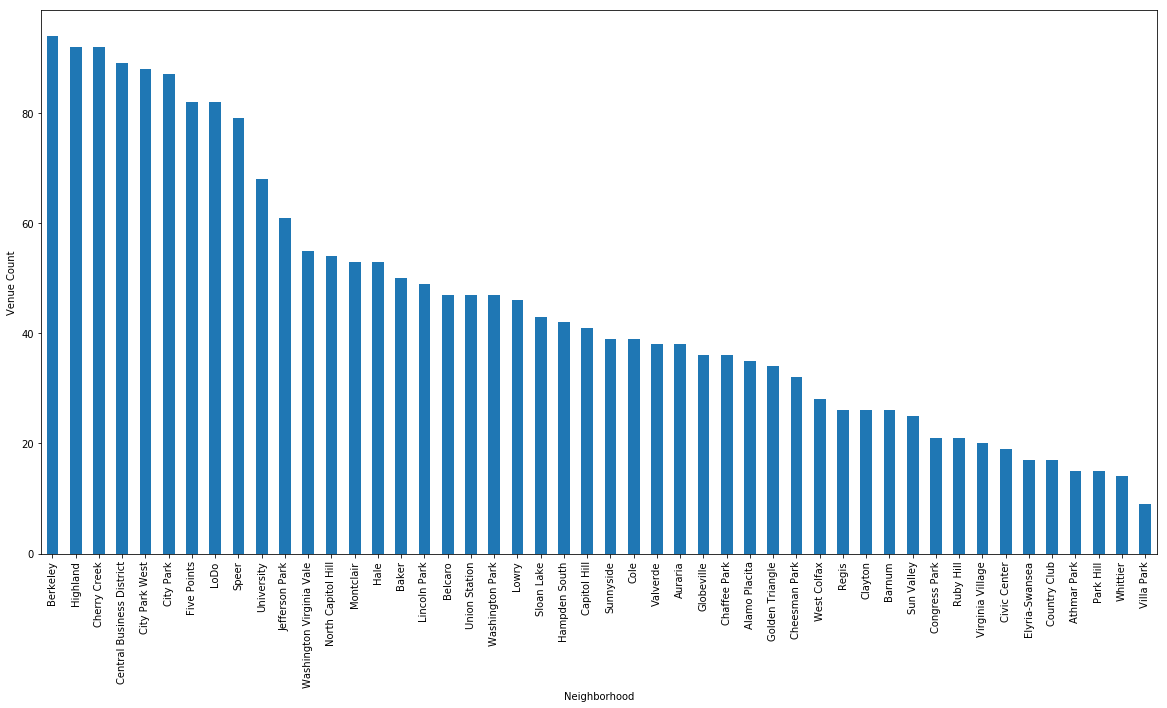

In [12]:
temp = denver_venues_reduced[['Neighborhood','Venue']].groupby(by='Neighborhood').count() \
                                                    .sort_values(by='Venue',ascending=False) \

ax = temp.plot.bar(figsize=(20,10))

ax.get_legend().remove()
ax.set_ylabel('Venue Count')

temp.describe()

There are a few neighborhoods with alarmingly low numbers of venues. Let's ignore these for now and deal with them if they cause issues during the clustering.

Let's see how many of each venue category there are. To keep the number of distinct categories relatively low, we'll remove categories with less than a dozen instances.

In [119]:
venue_counts = pd.DataFrame(denver_venues_reduced['Venue Category'].value_counts())

venue_counts.index = [row[0] if row[1]>11 else 'Other' for row \
                        in list(zip(venue_counts.index,venue_counts['Venue Category']))]

venue_counts = venue_counts.groupby(venue_counts.index).sum() \
                .sort_values(by='Venue Category',ascending=False) \
                .drop('Other', axis=0)

pd.DataFrame(denver_venues_reduced['Venue Category'].describe())

,Venue Category
count,2167
unique,283
top,Coffee Shop
freq,99


51


,Venue Category
count,51.000000
mean,27.666667
std,20.454502
min,12.000000
25%,13.500000
50%,19.000000
75%,35.000000
max,99.000000


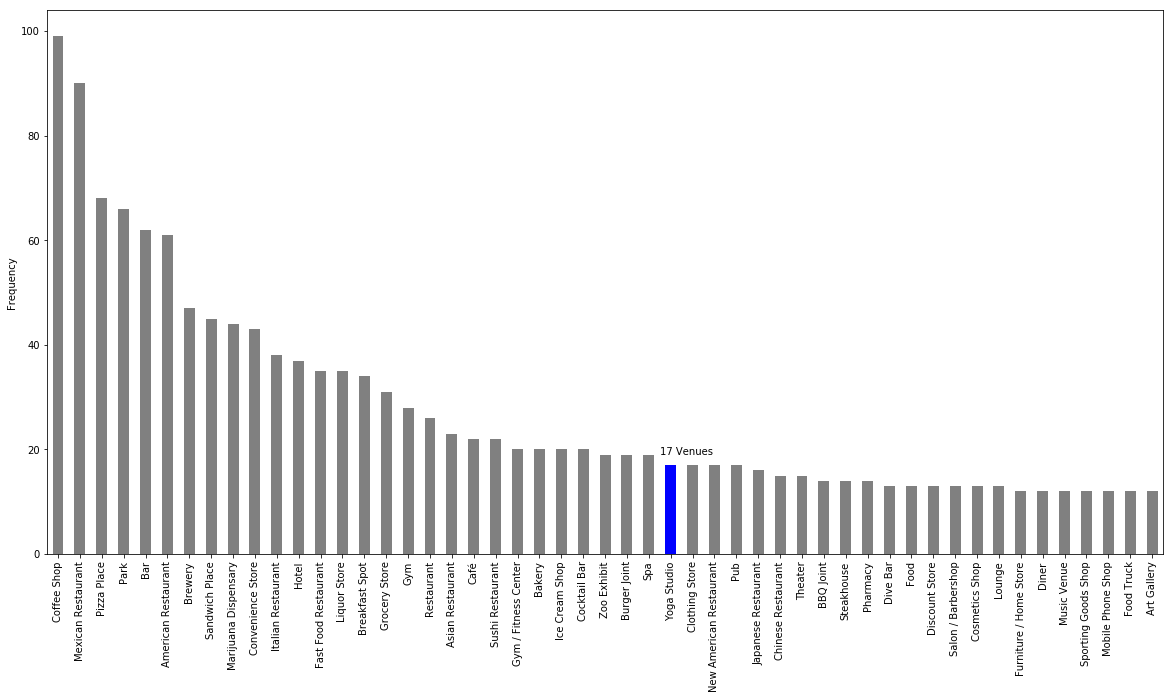

In [117]:
%matplotlib inline
c = ['b' if v=='Yoga Studio' else 'gray' for v in venue_counts.index]
ax = venue_counts.plot.bar(y='Venue Category', figsize=(20,10),color=c)
ax.get_legend().remove()
ax.set_ylabel('Frequency')
ax.annotate(str(venue_counts.loc['Yoga Studio'].values[0])+' Venues',xy=(27.5,19))

venue_counts.describe()

Now let's check for correlation between the number of yoga studios and the other venue categories. To do this, we'll use one-hot encoding to get a nice dataframe of the counts of the venues per neighborhood.

In [120]:
# one hot encoding
denver_onehot = pd.get_dummies(denver_venues_reduced[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
denver_onehot['Neighborhood'] = denver_venues_reduced['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [denver_onehot.columns[-1]] + list(denver_onehot.columns[:-1])
denver_onehot = denver_onehot[fixed_columns]

venue_counts = denver_onehot.groupby('Neighborhood').sum().reset_index()

venue_counts_temp = venue_counts

In [128]:
yoga_corr = pd.DataFrame(venue_counts.corr(method='spearman')['Yoga Studio'] \
                         .sort_values(ascending=False))

temp = yoga_corr[1:].head()
temp.rename({'Yoga Studio':'Correlation'},axis=1)

,Correlation
Italian Restaurant,0.529867
Frozen Yogurt Shop,0.493119
Taco Place,0.480119
Jewelry Store,0.431866
Asian Restaurant,0.405620


In [129]:
temp = yoga_corr.tail()
temp.rename({'Yoga Studio':'Correlation'},axis=1)

,Correlation
Vietnamese Restaurant,-0.228007
Convenience Store,-0.258593
Video Store,-0.270116
Food,-0.308076
Liquor Store,-0.404430


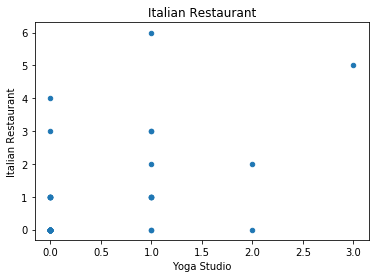

In [123]:
venue_counts.plot.scatter(x='Yoga Studio',y='Italian Restaurant',
                         title='Italian Restaurant')

We see from the venue counts that there are only a few yoga studios. This likely means that these correlations are a result of the size of the neighborhoods.

## K-Means Clustering

Let's standardize the data by turning venue type count into percent of total venues in the neighborhood.

In [137]:
venue_counts = venue_counts_temp
denver_grouped_portioned = denver_onehot.groupby('Neighborhood').mean().reset_index()
denver_grouped_clustering = denver_grouped_portioned.drop('Neighborhood', 1)
denver_grouped_clustering['Yoga Studio'] = denver_grouped_clustering['Yoga Studio']*3

Now we can determine k using elbow method.

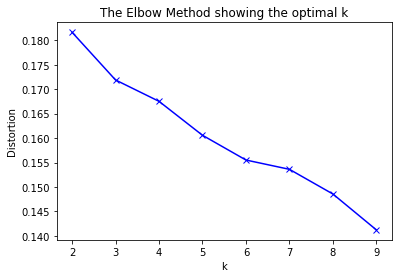

In [138]:
distortions = []
rand = 42
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=rand).fit(denver_grouped_clustering)
    kmeanModel.fit(denver_grouped_clustering)
    distortions.append(sum(np.min(cdist(denver_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / denver_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


Let's see if we can get anything out of this initial clustering.

In [139]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(denver_grouped_clustering)

Let's check how many neighborhoods are in each cluster and the number of yoga studios in each to be sure that they are account for.

In [140]:
venue_counts['Cluster'] = kmeans.labels_
yoga_df = venue_counts[['Cluster','Yoga Studio']].groupby('Cluster').sum()
yoga_df['Neighborhoods'] = venue_counts['Cluster'].value_counts().sort_index()
yoga_df['Average per Neighborhood'] = yoga_df['Yoga Studio']/yoga_df['Neighborhoods']
yoga_df

,Yoga Studio,Neighborhoods,Average per Neighborhood
Cluster,,,
0,2,1,2.00
1,15,20,0.75
2,0,17,0.00
3,0,1,0.00
4,0,5,0.00
5,0,4,0.00


Some of the neighborhoods are drastically different from the rest. Let's find out what they are.

In [141]:
# get the count of each venue category instance by neighborhood
denver_grouped_portioned['Cluster'] = kmeans.labels_

bad_clusters = list(yoga_df[(yoga_df['Neighborhoods']==1) | (yoga_df['Neighborhoods']==2)].index)
bad_neighborhoods = list(denver_grouped_portioned[[(x in bad_clusters) for x in denver_grouped_portioned['Cluster']]]['Neighborhood'])

print("Outlying neighborhoods include {}".format(", ".join(bad_neighborhoods)))

Outlying neighborhoods include Country Club, Villa Park


We saw earlier that these had very low venue counts, so it's logical that they are outliers.
Let's get rid of them and recluster.

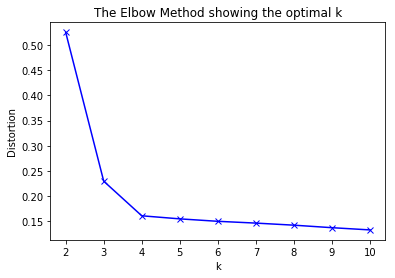

In [142]:
denver_grouped_portioned = denver_grouped_portioned[[x not in bad_neighborhoods for x in denver_grouped_portioned['Neighborhood']]]
denver_grouped_clustering = denver_grouped_portioned.drop('Neighborhood', 1)

venue_counts = venue_counts[[x not in bad_neighborhoods for x in venue_counts['Neighborhood']]]

# determine k using elbow method
distortions = []
K = range(2,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=rand).fit(denver_grouped_clustering)
    kmeanModel.fit(denver_grouped_clustering)
    distortions.append(sum(np.min(cdist(denver_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / denver_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [143]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(denver_grouped_clustering)

# get the count of each venue category instance by neighborhood
venue_counts['Cluster'] = kmeans.labels_
venue_counts.head()

yoga_df = venue_counts[['Cluster','Yoga Studio']].groupby('Cluster').sum()
yoga_df['Neighborhoods'] = venue_counts['Cluster'].value_counts().sort_index()
yoga_df['Average per Neighborhood'] = yoga_df['Yoga Studio']/yoga_df['Neighborhoods']
yoga_df

C:\Users\pservello\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Yoga Studio,Neighborhoods,Average per Neighborhood
Cluster,,,
0,15,20,0.75
1,0,5,0.00
2,0,17,0.00
3,0,4,0.00


These are decent results! We were hoping to see that the yoga studios were designated to the same cluster.

In [144]:
# create dataframe of neighborhood coordinates and clusters
denver_merged = df[[nbhd in set(denver_venues_reduced['Neighborhood']) for nbhd in df['Neighborhood']]]
denver_merged = denver_merged.merge(venue_counts[['Neighborhood','Cluster']])
denver_merged.head()

# create map
map_clusters = folium.Map(location=[39.719, -104.95], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.brg(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(denver_merged['Latitude'], denver_merged['Longitude'], denver_merged['Neighborhood'], denver_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [162]:
# find the average number of each venue category per cluster
venue_clusters = venue_counts.groupby('Cluster').mean()
venue_clusters = venue_clusters

# store the yoga cluster
avg_yoga_per_neighborhood = venue_clusters['Yoga Studio']
yoga_cluster = avg_yoga_per_neighborhood.idxmax()
print("Cluster {} has the highest average number of yoga studios per neighborhood.".format(yoga_cluster))

Cluster 0 has the highest average number of yoga studios per neighborhood.


What's different about this cluster? Are there more of a particular venue type than there are in other clusters?

In [163]:
venue_clusters.div(venue_clusters.sum(1),axis=0)
venue_clusters = venue_clusters.div(venue_clusters.sum(1),axis=0)

In [164]:
venue_clusters = venue_clusters.T
venue_clusters[venue_clusters.max(axis=1)==venue_clusters[yoga_cluster]].sort_values(by=yoga_cluster,ascending=False).head(10)

Cluster,0,1,2,3
American Restaurant,0.036855,0.013889,0.018598,0.000000
Italian Restaurant,0.027846,0.000000,0.005722,0.000000
Hotel,0.027027,0.020833,0.001431,0.000000
Restaurant,0.017199,0.013889,0.002861,0.013333
Zoo Exhibit,0.015561,0.000000,0.000000,0.000000
Cocktail Bar,0.015561,0.000000,0.001431,0.000000
Burger Joint,0.013923,0.006944,0.001431,0.000000
Asian Restaurant,0.013104,0.006944,0.008584,0.000000
Yoga Studio,0.012285,0.000000,0.000000,0.000000
Sushi Restaurant,0.012285,0.006944,0.008584,0.000000


There are more american and italian restaurants than there are in other neighborhoods (not just beer, coffee too!). Also, italian restaurants had the highest correlation to yoga studios, so it's good to see that it's up here.

Now, are there any neighborhoods in this cluster that do not have a yoga studio in them? If so, we should open one there!

In [165]:
solution = list(venue_counts[(venue_counts['Yoga Studio']==0) & (venue_counts['Cluster']==yoga_cluster)]['Neighborhood'])
print(', '.join(solution))

Auraria, Belcaro, Central Business District, Civic Center, Cole, LoDo, Lowry, Union Station


Let's see the the area where we are going to set up the new yoga studio.

In [170]:
# create map of Denver using latitude and longitude values
map_denver = folium.Map(location=[39.735, -104.96], zoom_start=13)

df_solution = df[[nbhd in solution for nbhd in df['Neighborhood']]]

# add markers to map
for lat, lng, borough, neighborhood in zip(df_solution['Latitude'], df_solution['Longitude'], df_solution['Area'], df_solution['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_denver)  
    
map_denver

Most of the prospective neighborhoods are at the heart of Denver. It is likely that there are no yoga studios in these parts because the typical revenue of a yoga studio is not sufficient to pay for rent downtown.

However, we could opt for a location next to the University of Denver or Lowry. My friend also wants to be a professor. Maybe he could teach at the university while he runs his yoga studio.